In [1]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-success" style="font-size: 14px; border-radius: 10px"><h4>[GO] TO @ 49902774d06d12d9f33d4abb9911168cba123234
</h4><pre>  ✅ No changes found in the ./TO packge.</pre></div>

The above check ensures an experiment is reproducible. 
That is, no local changes to the code are made which might affect the experiment,
and the source can always be reverted to this version.

Also an experiment can include quite alot of settings and configuration.
Bringing experiments in jupyter notebooks makes it immediately clear what has been done in what experiment.
For example, if all experiments are run from some main.py, this main file will evolve alot over the months.
Logging all the different parameterization/optimizer combinations and their settings can quickly become too messy.

# Demo (03/29)

**goal** This notebook serves as a blueprint for myself to make experiments reproducible and organized.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

from TO import Topology, run_experiment
from TO.models import BinaryElasticMembraneModel
from TO.parameterizations import Capsules
from TO.utils import get_fitness_values, get_best_config

Each TO problem *for now* consists of three main components:
- Topology: a data-container for describing the geometrical features of the design.
- Parameterization: a way for going from some design vector to a geometry.
- Model: the physics simulation.

A design vector is optimized using an Optimizer that produces some geometry through the Parameterization.
This Parameterization updates the Topology which then is passed to the physics Model. 
The physics Model then simulates the design of the new Topology and an Objective is calculated.

I think the following components should be added:
- Optimizer: for now only CMA-ES is used and is hard-coded.
- Objective: for now the compliance is calculated but is hard-coded.
- Constraints: like the objective.

In [3]:
topology = Topology(
    continuous=True, 
    domain=box(0, 0, 100, 50), 
    density=1.
)
parameterization = Capsules(
    topology, 
    symmetry_y=True, 
    n_components_x=3, 
    n_components_y=2, 
    n_samples=1000
)
model = BinaryElasticMembraneModel(
    topology, 
    thickness=1, 
    E11=25, 
    E22=1, 
    G12=0.5, 
    nu12=0.25, 
    Emin=1e-9
)

The random seed determines the random state of the inital configuration and the optimizer.

In [4]:
run_experiment(
    topology, parameterization, model,
    sigma0=0.25, budget=32, seed=1,
)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=1, Fri Mar 28 18:42:54 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.432174479272436e+04 1.0e+00 2.35e-01  2e-01  2e-01 0:00.0
    2     24 1.552652909241845e+04 1.1e+00 2.15e-01  2e-01  2e-01 0:00.1
    3     36 3.365340187960639e+04 1.2e+00 2.04e-01  2e-01  2e-01 0:00.3
   26    312 2.116664415392503e-01 1.7e+00 1.55e-01  1e-01  2e-01 0:03.3


We run the experiment of the tip-loading twice to see if it's reproducible. 

In [5]:
run_experiment(
    topology, parameterization, model,
    sigma0=0.25, budget=32, seed=1,
)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=1, Fri Mar 28 18:43:01 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.432174479272436e+04 1.0e+00 2.35e-01  2e-01  2e-01 0:00.1
    2     24 1.552652909241845e+04 1.1e+00 2.15e-01  2e-01  2e-01 0:00.2
    3     36 3.365340187960639e+04 1.2e+00 2.04e-01  2e-01  2e-01 0:00.3
   27    324 1.681087309344050e-01 1.7e+00 1.45e-01  1e-01  2e-01 0:03.4


In [6]:
all(get_fitness_values(1, 0) == get_fitness_values(1, 1))

True

We get the same fitness values. 
See how the logger somehow prints on different iterations.

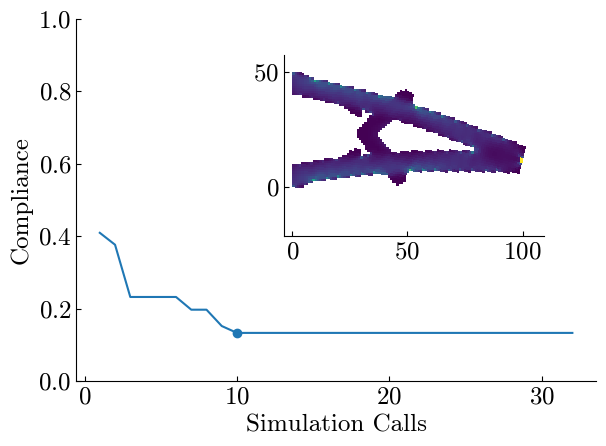

In [ ]:
# getting the fitness values of the simulation calls
f = get_fitness_values(1)
fmin = np.minimum.accumulate(f)

x_best = get_best_config(1)
parameterization.update_topology(topology, x_best)
# running the simulation one last time on best found config
model.update(topology) 
C = model.compute_element_compliance()

fig, ax = plt.subplots()
ins = ax.inset_axes([0.4,0.4,0.5,0.5])

ax.plot(fmin.argmin()+1, fmin.min(), 'C0o'); ax.plot(np.arange(fmin.size)+1, fmin); model.plot(C, fac=10, ax=ins); ins.axis('equal')
ax.set_ylim(0, 1); ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()